In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from swap_auditor import NaiveSwapAuditor

In [106]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [107]:
# Add 1st/2nd gen immigrant status 
# Native/non native english speaker

target_col = "GradesUndergrad" # Grades
nels_valid_grades = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Make binary decision >= 2.75 GPA
nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
nels_valid_grades = nels_valid_grades.sample(frac=1).reset_index(drop=True)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["Degree", 
"StudentId", 
"HighestPostSecondaryEducationAttained", 
"AttendedFirstChoicePostSecondaryEducation",
"JobSatisfaction", 
"Income",
"TotalEarningsJob1",
"TotalEarningsJob2",
"CoursesAt2To4YearCollege"]

nels_valid_grades = nels_valid_grades[nels_valid_grades.columns.difference(columns_to_withhold)]

X = nels_valid_grades[nels_valid_grades.columns.difference([target_col])]
y = nels_valid_grades[target_col]

C:\Users\Eliza\AppData\Local\Temp\ipykernel_9972\88887000.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)


In [108]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

nels_valid_grades = resample_up_down(nels_valid_grades, upsample=True, target_col=target_col)
X = nels_valid_grades.loc[:, nels_valid_grades.columns != target_col]
y = nels_valid_grades[target_col]  

1    6640
0    6640
Name: GradesUndergrad, dtype: int64


In [109]:
def return_real_column_name(human, human_list, yucky_list):
    return yucky_list[human_list.index(human)]

human_list = nels_columns_readable.columns.tolist()
yucky_list = nels_columns.columns.tolist()
return_real_column_name('Race', human_list, yucky_list)

'F4RACEM'

In [110]:
toy_columns = ['StudentId',
# .66 Acc RF
'Sex',
'Race',
'CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',

# .86 Acc RF (with base), .96 (second two), .58 (alone)
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',
'HelpWithEssays',
'ParentsCheckHomework',

# .92 Acc FR (with base), .82 (alone)
'HighSchoolHelpedWithSchoolApplication',
'HelpedWithFinancialAidApp',
'ParentsHighestLevelEducation',
'Socio-economicStatusQuartile',
'PrivateSchoolExpenses',
'PrivateTutoringExpenses',
'Tutored',
'FathersWishes',
'MothersWishes',

'GradesUndergrad']

In [111]:
# Only valid grades
toy_dataframe = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Only white/black nonhispanic
toy_dataframe = toy_dataframe[(3 <= toy_dataframe['Race']) & (toy_dataframe['Race'] <= 4)]

# Shuffle randomly before training models
toy_dataframe = toy_dataframe.sample(frac=1).reset_index(drop=True)

toy_dataframe = toy_dataframe[toy_columns]

# Make binary decision >= 2.75 GPA
toy_dataframe[target_col] = np.where(toy_dataframe[target_col] <= 3, 1, 0)
make_string = False

if make_string:
    # Make binary decision >= 2.75 GPA
    toy_dataframe["Race"] = np.where(toy_dataframe["Race"] == 3, "Black", "White")
    toy_dataframe["Sex"] = np.where(toy_dataframe["Sex"] == 1, "Male", "Female")

toy_dataframe = resample_up_down(toy_dataframe, upsample=True, target_col=target_col)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["StudentId"]

X = toy_dataframe[toy_dataframe.columns.difference([target_col]+columns_to_withhold)]
y = toy_dataframe[target_col]

1    5154
0    5154
Name: GradesUndergrad, dtype: int64


In [112]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1048
           1       0.97      0.90      0.93      1014

    accuracy                           0.94      2062
   macro avg       0.94      0.94      0.94      2062
weighted avg       0.94      0.94      0.94      2062



### CDF of stability per protected class and intersectional protected classes

In [142]:
tiny_test = toy_dataframe[:500]
student = int(tiny_test.iloc[0]['StudentId'])

In [114]:
new = NaiveSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
new.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'])

In [143]:
def get_stability(ind):
    return new._retrieve_stability_individual(ind)[0]

tiny_test['stability'] = tiny_test.apply(lambda x: get_stability(x.StudentId), axis=1)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_9972\2943892046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiny_test['stability'] = tiny_test.apply(lambda x: get_stability(x.StudentId), axis=1)


In [246]:
def plot_density(dfs, labels, outcome, ax):
    for i in range(len(dfs)):
        df = dfs[i]
        sns.kdeplot(df[outcome], ax=ax, label=labels[i])

    ax.set_title('Synth ('+str(outcome)+')')
    ax.set_xlabel('Outcomes')
    ax.legend()


In [162]:
# sex: 1 = M, 2 = F
# race: 3 = Black, 4 = white

def plot_cdf(df, feature, students, plot_index):
    y_feature = list(df[feature])
    y_feature.sort()

    bins = [x/10 for x in range(11)]
    pdf, bin_edges = np.histogram(y_feature, bins=bins)
    pdf = pdf/len(y_feature)
    cdf = np.cumsum(pdf)

    plt.subplot(plot_index)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} for {students} students')
    plt.legend()

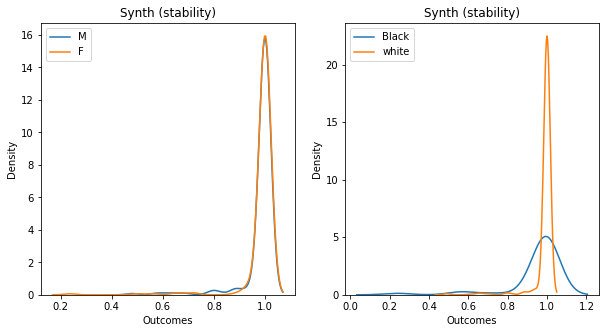

In [248]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
plot_density([tiny_test.loc[tiny_test['Sex'] == 1], tiny_test.loc[tiny_test['Sex'] == 2]], ['M', 'F'], 'stability', ax[0])
plot_density([tiny_test.loc[tiny_test['Race'] == 3], tiny_test.loc[tiny_test['Race'] == 4]], ['Black', 'white'], 'stability', ax[1])

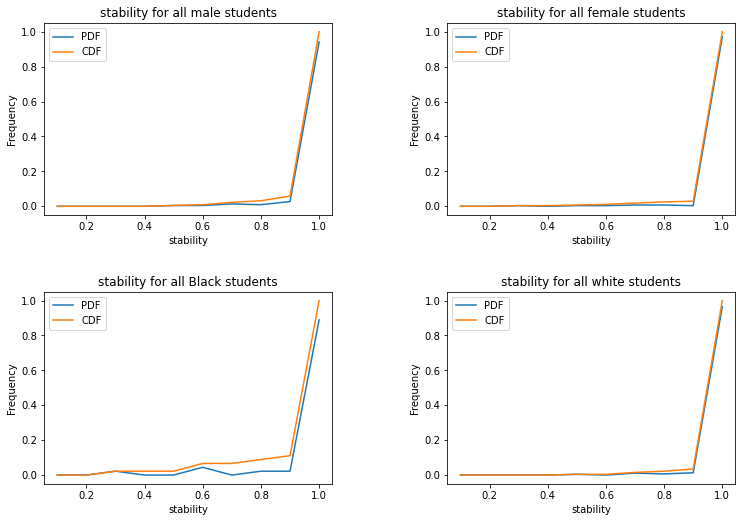

In [163]:
# plot stabilities of each subgroup
plt.figure(figsize=(12, 8))

plot_cdf(tiny_test.loc[tiny_test['Sex'] == 1], 'stability', 'all male', 221)
plot_cdf(tiny_test.loc[tiny_test['Sex'] == 2], 'stability', 'all female', 222)
plot_cdf(tiny_test.loc[tiny_test['Race'] == 3], 'stability', 'all Black', 223)
plot_cdf(tiny_test.loc[tiny_test['Race'] == 4], 'stability', 'all white', 224)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

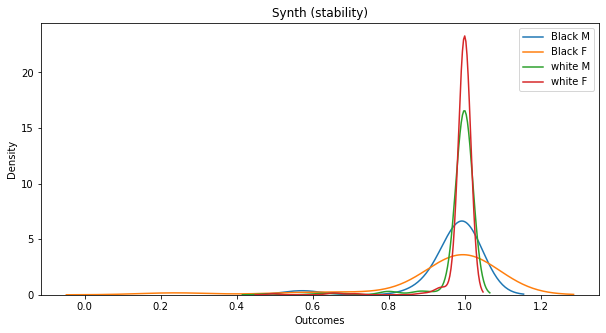

In [252]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
plot_density([tiny_test.loc[(tiny_test['Sex'] == 1) & (tiny_test['Race'] == 3)], 
              tiny_test.loc[(tiny_test['Sex'] == 2) & (tiny_test['Race'] == 3)],
              tiny_test.loc[(tiny_test['Sex'] == 1) & (tiny_test['Race'] == 4)],
              tiny_test.loc[(tiny_test['Sex'] == 2) & (tiny_test['Race'] == 4)]], ['Black M', 'Black F', 'white M', 'white F'], 'stability', ax)

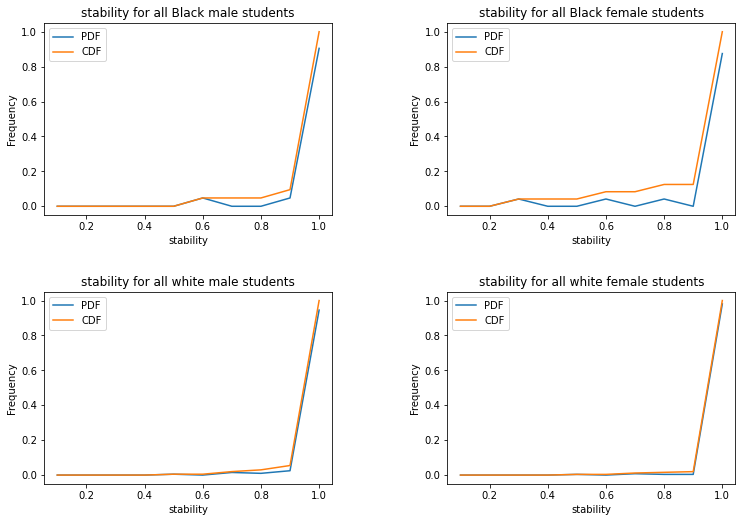

In [164]:
# plot stabilities of each intersectional subgroup
plt.figure(figsize=(12, 8))

plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 1) & (tiny_test['Race'] == 3)], 'stability', 'all Black male', 221) 
plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 2) & (tiny_test['Race'] == 3)], 'stability', 'all Black female', 222)
plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 1) & (tiny_test['Race'] == 4)], 'stability', 'all white male', 223)
plot_cdf(tiny_test.loc[(tiny_test['Sex'] == 2) & (tiny_test['Race'] == 4)], 'stability', 'all white female', 224)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

### Comparing distributions of features based on inflection points in stability

In [165]:
def get_individual_stability(new, id):
    return new._retrieve_stability_individual(id)[0]

def construct_df(marginal_features):
    df = toy_dataframe[:500]
    new = NaiveSwapAuditor(data=df, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
    new.calculate_all_stability(marginal_features=marginal_features)

    df['stability'] = df.apply(lambda x: get_individual_stability(new, x.StudentId), axis=1)

    return df

In [166]:
def plot_stability_cdfs(df):
    plt.figure(figsize=(12, 8))

    plot_cdf(df.loc[df['Race'] == 3], 'stability', 'all Black', 221)
    plot_cdf(df.loc[df['Race'] == 4], 'stability', 'all white', 222)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)


In [216]:
def plot_features(black_under, black_over, white_over, features, stability_inflection):
    for i in range(len(features)):
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)
        feature = features[i]

        axs = ax[0]
        sns.kdeplot(black_under[feature], ax=axs, label=f'Black (stability < {stability_inflection})')
        sns.kdeplot(white_over[feature], ax=axs, label=f'White (stability >= {stability_inflection})')
        axs.set_title('Synth ('+str(feature)+')')
        axs.set_xlabel('Outcomes')
        axs.legend()

        axs = ax[1]
        sns.kdeplot(black_over[feature], ax=axs, label=f'Black (stability >= {stability_inflection})')
        sns.kdeplot(white_over[feature], ax=axs, label=f'White (stability >= {stability_inflection})')
        axs.set_title('Synth ('+str(feature)+')')
        axs.set_xlabel('Outcomes')
        axs.legend()
    

C:\Users\Eliza\AppData\Local\Temp\ipykernel_9972\1808879477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stability'] = df.apply(lambda x: get_individual_stability(new, x.StudentId), axis=1)
C:\Users\Eliza\anaconda3\envs\stability_exp_env\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_9972\1808879477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

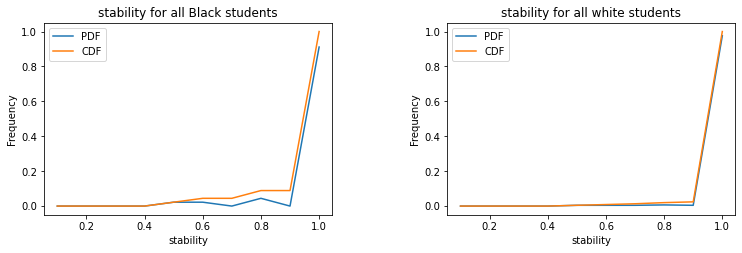

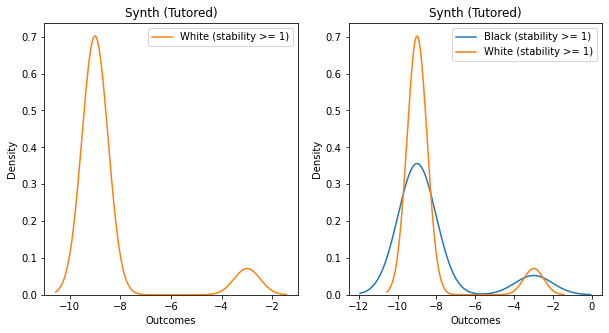

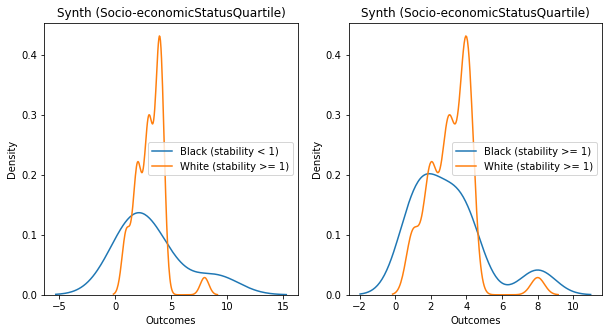

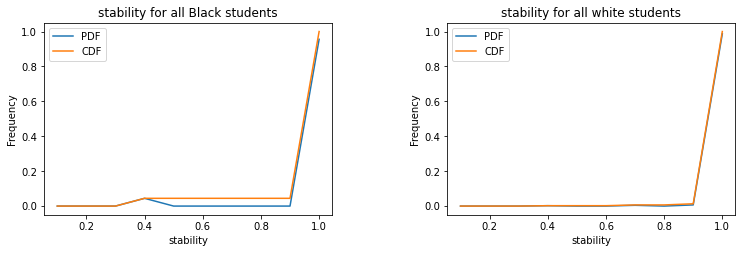

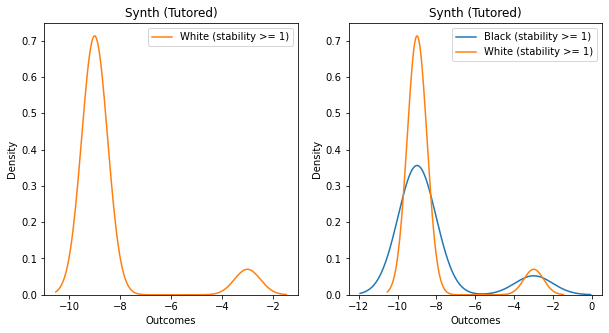

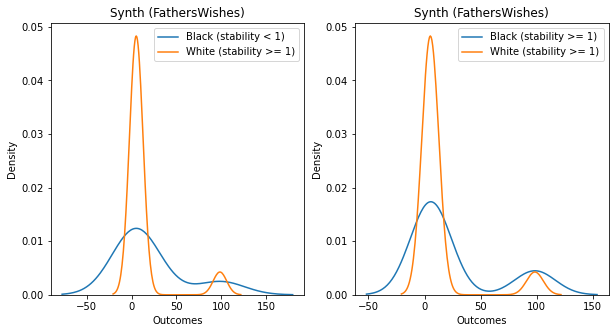

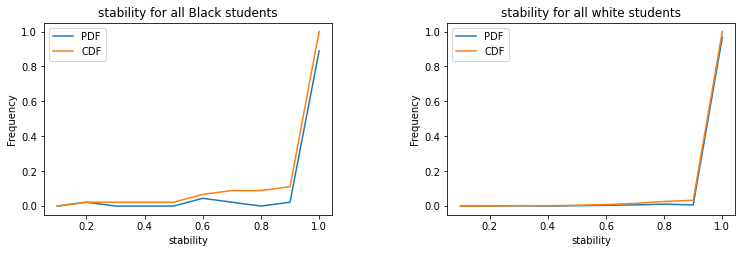

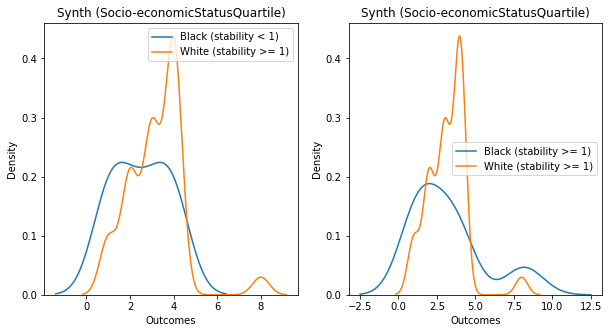

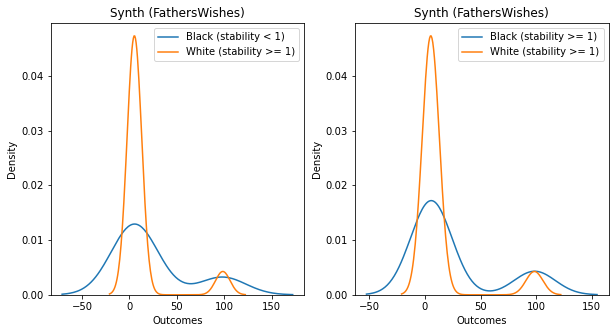

In [286]:
import itertools
marginal_features_all= ['Tutored','Socio-economicStatusQuartile', 'FathersWishes']
marginal_features = list(itertools.combinations(marginal_features_all, 2))

df_black_under = set()
df_white_over = set()
stability_inflection = 1
for marg_pair in marginal_features:
    df = construct_df(marg_pair)
    black_under = df[(df['Race'] == 3) & (df['stability'] < stability_inflection)]
    black_over = df[(df['Race'] == 3) & (df['stability'] >= stability_inflection)]
    white_over = df[(df['Race'] == 4) & (df['stability'] >= stability_inflection)]

    df_black_under.update(list(black_under['StudentId']))
    df_white_over.update(list(white_over['StudentId']))

    plot_stability_cdfs(df)
    plot_features(df, marg_pair, stability_inflection)

In [288]:
print(f'Black students with stability < {stability_inflection}: {len(df_black_under)}')
print(f'White students with stability >= {stability_inflection}: {len(df_white_over)}')

Black students with stability < 1: 11
White students with stability >= 1: 444
